In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from ecg_anomaly_classification.data_api.data_api import read_ecg, load_train_set, load_validation_set, load_test_set
from ecg_anomaly_classification.data_api.dataset import ECGDataset

np.random.seed(42)

In [2]:
with open("config.yaml") as config_file:
    config = yaml.full_load(config_file)

### Read data

In [3]:
df_train = load_train_set(**config)
df_validation = load_validation_set(**config)
df_test = load_test_set(**config)

### Descriptive statistics

In [4]:
print(f"Train set size = {df_train.shape[0]}\nValidation set size = {df_validation.shape[0]}\nTest set size = {df_test.shape[0]}")

Train set size = 17441
Validation set size = 2193
Test set size = 2203


In [5]:
print(f"Train set normal samples fraction = {df_train.target.mean()}\n\
Validation normal samples fraction = {df_validation.target.mean()}\n\
Test set normal samples fraction = {df_test.target.mean()}")

Train set normal samples fraction = 0.43615618370506276
Validation normal samples fraction = 0.4363885088919289
Test set normal samples fraction = 0.4375851112119837


In [6]:
normal_samples = df_train[df_train.target == 1]
anomaly_samples = df_train[df_train.target == 0]

In [7]:
samples_number = 4

In [8]:
normal_signals = [read_ecg(os.path.join(config["ptb_path"], name)) for name in normal_samples.sample(samples_number)["filename_lr"]]
anomaly_signals = [read_ecg(os.path.join(config["ptb_path"], name)) for name in anomaly_samples.sample(samples_number)["filename_lr"]]

In [9]:
print(f"Number of time steps = {normal_signals[0].shape[0]}\nNumber of channels = {normal_signals[0].shape[1]}")

Number of time steps = 1000
Number of channels = 12


### Visualize signals

In [10]:
fs = 100
v1_channel = 4

#### Time domain

In [11]:
# Function for plotting a signal
def plot_signal(x, y, y_label, x_label, ax, vis_type="curve", color="b"):
    if vis_type == "curve":
        ax.plot(x, y)
    elif vis_type == "stem":
        ax.stem(x, y, color, markerfmt=color+"o")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [12]:
t = np.arange(1000) / fs

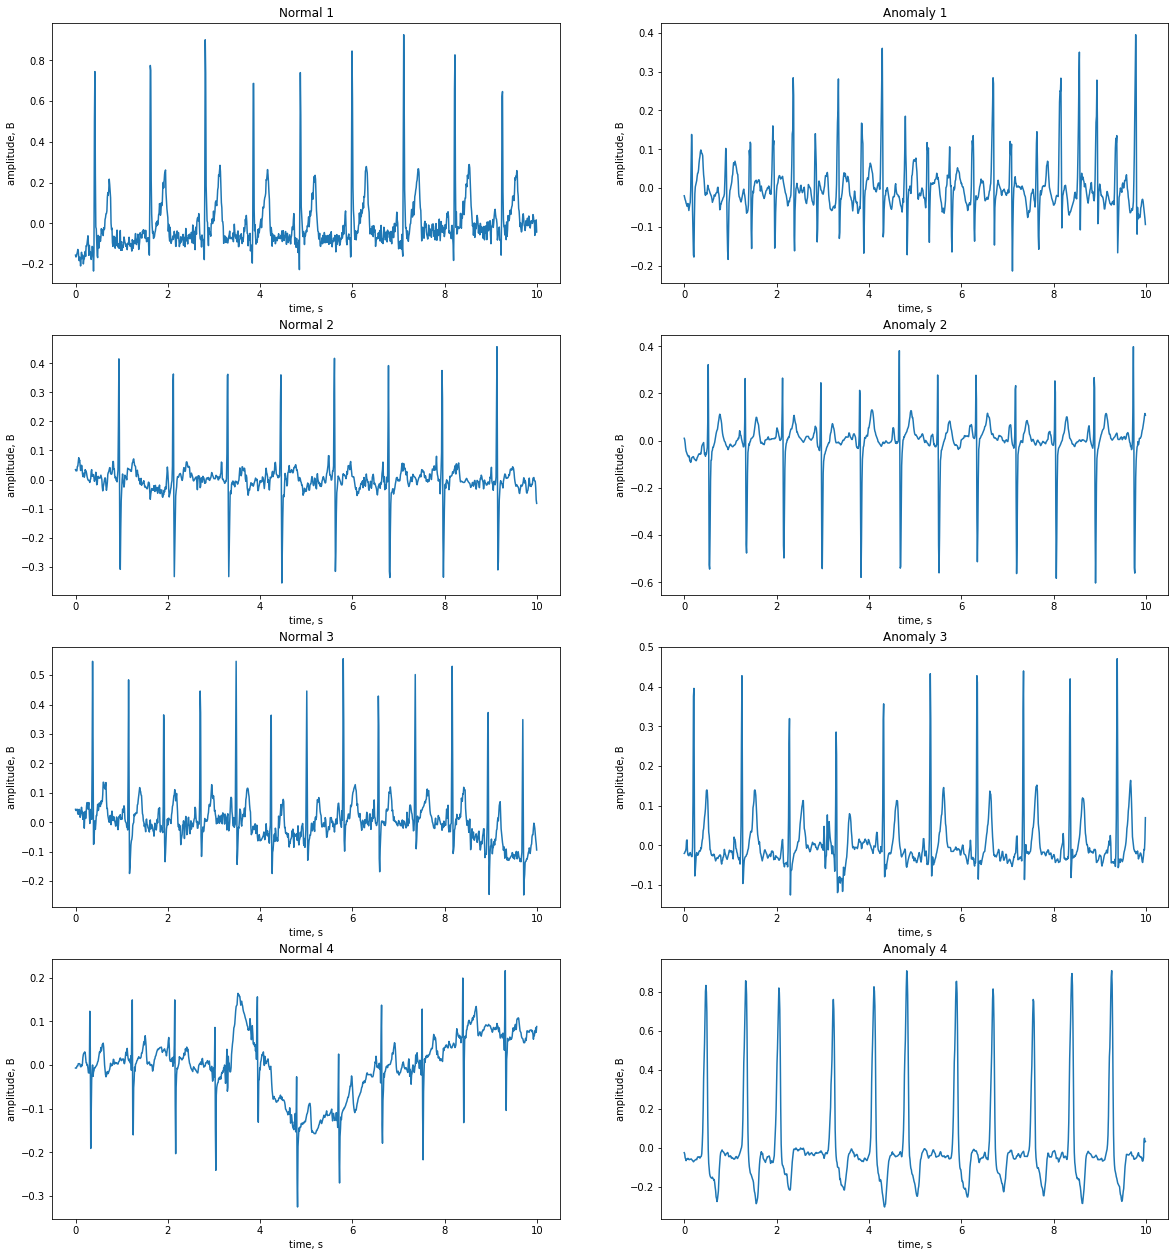

In [13]:
fig, axes = plt.subplots(nrows=samples_number, ncols=2, figsize=(20, 22))

for i in range(samples_number):
    plot_signal(t, normal_signals[i][:, v1_channel], "amplitude, B", "time, s", ax=axes[i][0])
    axes[i][0].set_title(f"Normal {i + 1}")

    plot_signal(t, anomaly_signals[i][:, v1_channel], "amplitude, B", "time, s", ax=axes[i][1])
    axes[i][1].set_title(f"Anomaly {i + 1}")

#### Time-frequency domain

In [14]:
def plot_spectrogram(f, t, sxx, ax):
    ax.pcolormesh(t, f, sxx, shading="gouraud")
    ax.set_ylabel("frequency, Hz")
    ax.set_xlabel("time ,s")

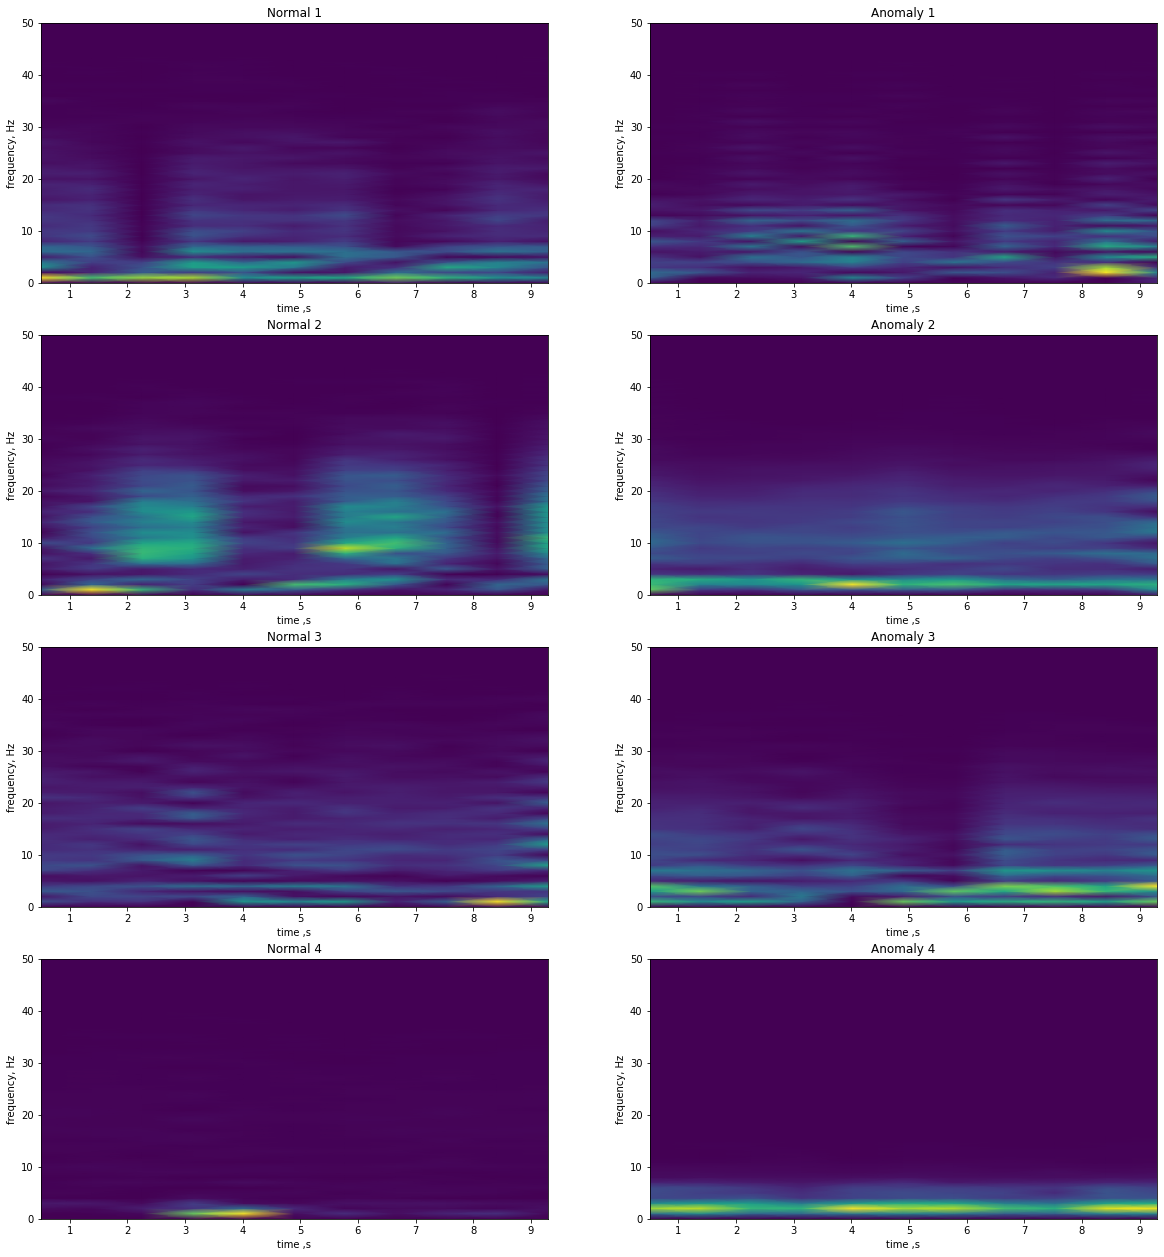

In [31]:
fig, axes = plt.subplots(nrows=samples_number, ncols=2, figsize=(20, 22))

for i in range(samples_number):
    plot_spectrogram(*signal.spectrogram(normal_signals[i][:, v1_channel], fs, nperseg=100), ax=axes[i][0])
    axes[i][0].set_title(f"Normal {i + 1}")

    plot_spectrogram(*signal.spectrogram(anomaly_signals[i][:, v1_channel], fs, nperseg=100), ax=axes[i][1])
    axes[i][1].set_title(f"Anomaly {i + 1}")

#### Wavelet transfrom

In [32]:
def plot_scalogram(s, t, sxx, ax):
    ax.pcolormesh(t, s, sxx, shading="gouraud")
    ax.set_ylabel("scaling factor")
    ax.set_xlabel("time ,s")

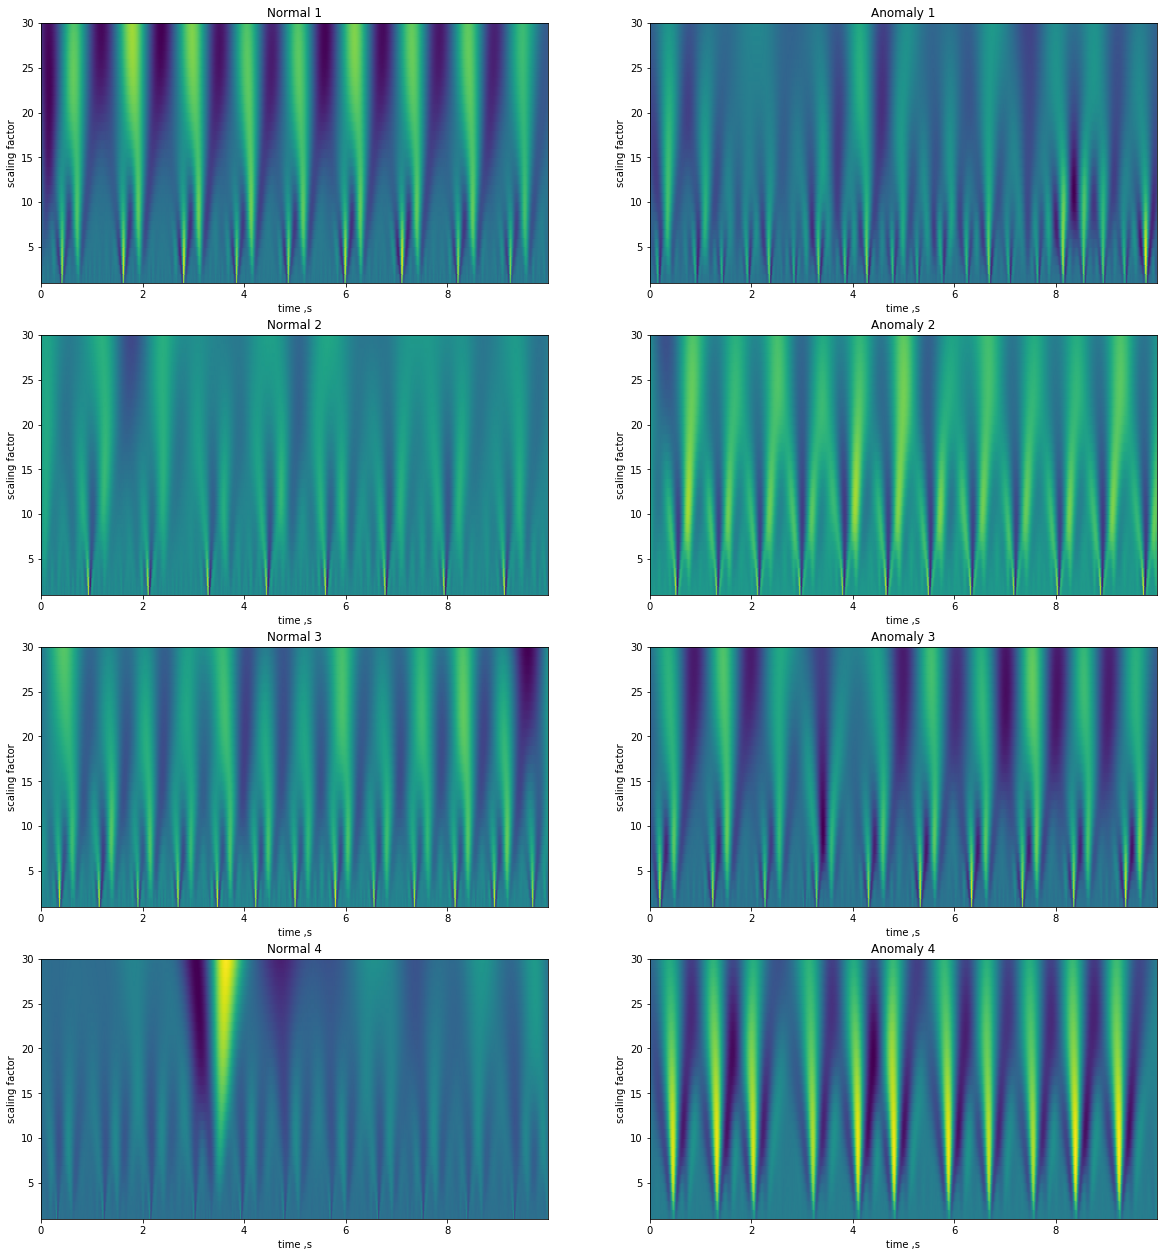

In [33]:
fig, axes = plt.subplots(nrows=samples_number, ncols=2, figsize=(20, 22))

width = np.arange(1, 31)
for i in range(samples_number):
    plot_scalogram(width, t, signal.cwt(normal_signals[i][:, v1_channel], signal.ricker, width), ax=axes[i][0])
    axes[i][0].set_title(f"Normal {i + 1}")

    plot_scalogram(width, t, signal.cwt(anomaly_signals[i][:, v1_channel], signal.ricker, width), ax=axes[i][1])
    axes[i][1].set_title(f"Anomaly {i + 1}")